In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 9):
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15996, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5332, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 42656)             0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_10 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_10 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_11 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_11 (Activation)   (None, 5328, 16)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_28 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_28 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_29 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_29 (Activation)   (None, 5328, 16)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.8694 - acc: 0.1739
Epoch 00001: val_loss improved from inf to 2.46351, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_1_conv_checkpoint/001-2.4635.hdf5
36805/36805 [==============================] - 10s 264us/sample - loss: 2.8686 - acc: 0.1742 - val_loss: 2.4635 - val_acc: 0.2001
Epoch 2/500
36608/36805 [============================>.] - ETA: 0s - loss: 2.2827 - acc: 0.2908
Epoch 00002: val_loss improved from 2.46351 to 2.26946, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_1_conv_checkpoint/002-2.2695.hdf5
36805/36805 [==============================] - 8s 217us/sample - loss: 2.2822 - acc: 0.2910 - val_loss: 2.2695 - val_acc: 0.3003
Epoch 3/500
36544/36805 [============================>.] - ETA: 0s - loss: 2.0109 - acc: 0.3685
Epoch 00003: val_loss improved from 2.26946 to 2.22027

36736/36805 [============================>.] - ETA: 0s - loss: 0.9840 - acc: 0.6840
Epoch 00028: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 216us/sample - loss: 0.9842 - acc: 0.6839 - val_loss: 2.7383 - val_acc: 0.3270
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9800 - acc: 0.6833
Epoch 00029: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 213us/sample - loss: 0.9800 - acc: 0.6832 - val_loss: 2.7014 - val_acc: 0.3277
Epoch 30/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9627 - acc: 0.6887
Epoch 00030: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 212us/sample - loss: 0.9632 - acc: 0.6885 - val_loss: 2.9535 - val_acc: 0.2991
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9537 - acc: 0.6890
Epoch 00031: val_loss did not improve from 2.16924
36805/36805 [=====================

Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8140 - acc: 0.7336
Epoch 00058: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 218us/sample - loss: 0.8142 - acc: 0.7335 - val_loss: 3.0302 - val_acc: 0.3317
Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8120 - acc: 0.7348
Epoch 00059: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 226us/sample - loss: 0.8122 - acc: 0.7348 - val_loss: 2.8443 - val_acc: 0.3552
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8098 - acc: 0.7352
Epoch 00060: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 225us/sample - loss: 0.8099 - acc: 0.7352 - val_loss: 3.0418 - val_acc: 0.3224
Epoch 61/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8050 - acc: 0.7345
Epoch 00061: val_loss did not improve from 2.16924
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7364 - acc: 0.7586
Epoch 00088: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 215us/sample - loss: 0.7364 - acc: 0.7586 - val_loss: 2.9461 - val_acc: 0.3510
Epoch 89/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.7314 - acc: 0.7619
Epoch 00089: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 211us/sample - loss: 0.7318 - acc: 0.7616 - val_loss: 3.1086 - val_acc: 0.3366
Epoch 90/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.7346 - acc: 0.7614
Epoch 00090: val_loss did not improve from 2.16924
36805/36805 [==============================] - 8s 215us/sample - loss: 0.7345 - acc: 0.7613 - val_loss: 3.1454 - val_acc: 0.3457
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7221 - acc: 0.7632
Epoch 00091: val_loss did not improve from 2.16924
36805/36805 [========

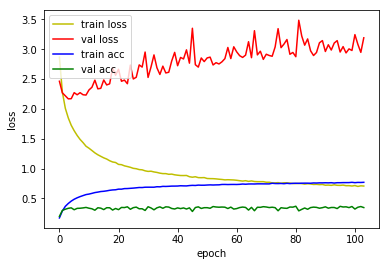

4815/4815 [==============================] - 1s 174us/sample - loss: 2.2044 - acc: 0.3171
Loss: 2.20443851611077 Accuracy: 0.31713396

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7976 - acc: 0.2080
Epoch 00001: val_loss improved from inf to 2.32704, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_2_conv_checkpoint/001-2.3270.hdf5
36805/36805 [==============================] - 13s 351us/sample - loss: 2.7957 - acc: 0.2084 - val_loss: 2.3270 - val_acc: 0.2544
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0270 - acc: 0.3609
Epoch 00002: val_loss improved from 2.32704 to 1.80522, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_2_conv_checkpoint/002-1.8052.hdf5
36805/36805 [==============================] - 11s 299us/sample - loss: 2.0269 - acc: 0.3609 - val_loss: 1.8052 - val_acc: 0.4368
Epoch 3/500
36736/36805 [============================>.] - ETA

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6722 - acc: 0.7764
Epoch 00028: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 294us/sample - loss: 0.6722 - acc: 0.7764 - val_loss: 1.5465 - val_acc: 0.5609
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6592 - acc: 0.7818
Epoch 00029: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 293us/sample - loss: 0.6592 - acc: 0.7818 - val_loss: 1.5904 - val_acc: 0.5546
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6494 - acc: 0.7847
Epoch 00030: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 292us/sample - loss: 0.6491 - acc: 0.7848 - val_loss: 1.5511 - val_acc: 0.5663
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6370 - acc: 0.7882
Epoch 00031: val_loss did not improve from 1.50410
36805/36805 [=====

Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4426 - acc: 0.8518
Epoch 00058: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 291us/sample - loss: 0.4428 - acc: 0.8516 - val_loss: 1.6390 - val_acc: 0.5754
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4363 - acc: 0.8549
Epoch 00059: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 296us/sample - loss: 0.4363 - acc: 0.8549 - val_loss: 1.7306 - val_acc: 0.5574
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4373 - acc: 0.8541
Epoch 00060: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 292us/sample - loss: 0.4373 - acc: 0.8541 - val_loss: 1.9023 - val_acc: 0.5313
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4337 - acc: 0.8555
Epoch 00061: val_loss did not improve from 1.50410
36805/36805 [=====

Epoch 88/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3396 - acc: 0.8885
Epoch 00088: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 295us/sample - loss: 0.3404 - acc: 0.8883 - val_loss: 1.7220 - val_acc: 0.5921
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3427 - acc: 0.8864
Epoch 00089: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 295us/sample - loss: 0.3423 - acc: 0.8866 - val_loss: 1.6527 - val_acc: 0.6033
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3367 - acc: 0.8892
Epoch 00090: val_loss did not improve from 1.50410
36805/36805 [==============================] - 11s 294us/sample - loss: 0.3367 - acc: 0.8892 - val_loss: 1.7069 - val_acc: 0.5975
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3411 - acc: 0.8868
Epoch 00091: val_loss did not improve from 1.50410
36805/36805 [=====

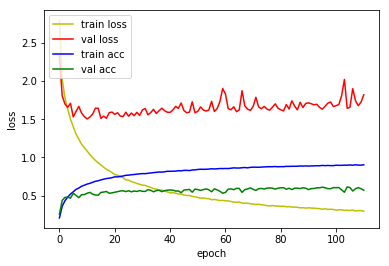

4815/4815 [==============================] - 1s 198us/sample - loss: 1.6162 - acc: 0.4974
Loss: 1.6161952246510476 Accuracy: 0.49740395

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7263 - acc: 0.2147
Epoch 00001: val_loss improved from inf to 1.92165, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_3_conv_checkpoint/001-1.9216.hdf5
36805/36805 [==============================] - 16s 433us/sample - loss: 2.7246 - acc: 0.2151 - val_loss: 1.9216 - val_acc: 0.3871
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.9143 - acc: 0.3943
Epoch 00002: val_loss improved from 1.92165 to 1.58588, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_3_conv_checkpoint/002-1.5859.hdf5
36805/36805 [==============================] - 13s 354us/sample - loss: 1.9139 - acc: 0.3943 - val_loss: 1.5859 - val_acc: 0.4845
Epoch 3/500
36736/36805 [============================>.] - E

Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6582 - acc: 0.7911
Epoch 00025: val_loss did not improve from 1.02738
36805/36805 [==============================] - 13s 348us/sample - loss: 0.6586 - acc: 0.7911 - val_loss: 1.1028 - val_acc: 0.6816
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6371 - acc: 0.7971
Epoch 00026: val_loss did not improve from 1.02738
36805/36805 [==============================] - 13s 348us/sample - loss: 0.6373 - acc: 0.7971 - val_loss: 1.0505 - val_acc: 0.7007
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6264 - acc: 0.8017
Epoch 00027: val_loss improved from 1.02738 to 1.02227, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_3_conv_checkpoint/027-1.0223.hdf5
36805/36805 [==============================] - 13s 348us/sample - loss: 0.6267 - acc: 0.8017 - val_loss: 1.0223 - val_acc: 0.7042
Epoch 28/500
36736/36805 [============================>.] - ETA:

Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4047 - acc: 0.8683
Epoch 00054: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 347us/sample - loss: 0.4047 - acc: 0.8683 - val_loss: 1.0514 - val_acc: 0.7149
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4015 - acc: 0.8690
Epoch 00055: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 350us/sample - loss: 0.4020 - acc: 0.8688 - val_loss: 1.0734 - val_acc: 0.7095
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3961 - acc: 0.8715
Epoch 00056: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 348us/sample - loss: 0.3964 - acc: 0.8713 - val_loss: 1.0554 - val_acc: 0.7172
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3964 - acc: 0.8685
Epoch 00057: val_loss did not improve from 1.00592
36805/36805 [=====

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3069 - acc: 0.9016
Epoch 00084: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 350us/sample - loss: 0.3071 - acc: 0.9015 - val_loss: 1.1294 - val_acc: 0.7151
Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.9005
Epoch 00085: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 350us/sample - loss: 0.3017 - acc: 0.9003 - val_loss: 1.2162 - val_acc: 0.6925
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9034
Epoch 00086: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 344us/sample - loss: 0.2955 - acc: 0.9032 - val_loss: 1.0474 - val_acc: 0.7317
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2937 - acc: 0.9052
Epoch 00087: val_loss did not improve from 1.00592
36805/36805 [=====

Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2461 - acc: 0.9207
Epoch 00114: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 346us/sample - loss: 0.2459 - acc: 0.9207 - val_loss: 1.0372 - val_acc: 0.7496
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2544 - acc: 0.9190
Epoch 00115: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 343us/sample - loss: 0.2543 - acc: 0.9190 - val_loss: 1.0368 - val_acc: 0.7454
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2424 - acc: 0.9222
Epoch 00116: val_loss did not improve from 1.00592
36805/36805 [==============================] - 13s 346us/sample - loss: 0.2424 - acc: 0.9222 - val_loss: 1.0591 - val_acc: 0.7428
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2427 - acc: 0.9226
Epoch 00117: val_loss did not improve from 1.00592
36805/36805 [=

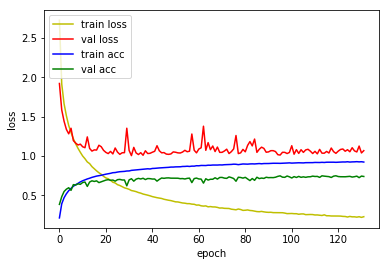

4815/4815 [==============================] - 1s 240us/sample - loss: 1.1109 - acc: 0.6725
Loss: 1.1108930741143745 Accuracy: 0.67248183

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6571 - acc: 0.2215
Epoch 00001: val_loss improved from inf to 1.89579, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/001-1.8958.hdf5
36805/36805 [==============================] - 19s 519us/sample - loss: 2.6571 - acc: 0.2216 - val_loss: 1.8958 - val_acc: 0.3692
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8111 - acc: 0.4259
Epoch 00002: val_loss improved from 1.89579 to 1.34169, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/002-1.3417.hdf5
36805/36805 [==============================] - 15s 398us/sample - loss: 1.8111 - acc: 0.4259 - val_loss: 1.3417 - val_acc: 0.5700
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 25/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6387 - acc: 0.8008
Epoch 00025: val_loss did not improve from 0.80869
36805/36805 [==============================] - 15s 403us/sample - loss: 0.6387 - acc: 0.8008 - val_loss: 0.8426 - val_acc: 0.7573
Epoch 26/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6272 - acc: 0.8043
Epoch 00026: val_loss did not improve from 0.80869
36805/36805 [==============================] - 15s 401us/sample - loss: 0.6275 - acc: 0.8042 - val_loss: 0.8335 - val_acc: 0.7652
Epoch 27/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6104 - acc: 0.8115
Epoch 00027: val_loss improved from 0.80869 to 0.76895, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/027-0.7689.hdf5
36805/36805 [==============================] - 15s 403us/sample - loss: 0.6107 - acc: 0.8114 - val_loss: 0.7689 - val_acc: 0.7899
Epoch 28/500
36672/36805 [============================>.] - ETA:

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3995 - acc: 0.8721
Epoch 00054: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 397us/sample - loss: 0.3995 - acc: 0.8721 - val_loss: 0.8056 - val_acc: 0.7817
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3863 - acc: 0.8763
Epoch 00055: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 401us/sample - loss: 0.3864 - acc: 0.8763 - val_loss: 0.8366 - val_acc: 0.7708
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3884 - acc: 0.8744
Epoch 00056: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 399us/sample - loss: 0.3883 - acc: 0.8743 - val_loss: 0.8197 - val_acc: 0.7761
Epoch 57/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3790 - acc: 0.8785
Epoch 00057: val_loss did not improve from 0.74259
36805/36805 [=====

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2867 - acc: 0.9062
Epoch 00084: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 400us/sample - loss: 0.2869 - acc: 0.9062 - val_loss: 0.8166 - val_acc: 0.7848
Epoch 85/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2817 - acc: 0.9079
Epoch 00085: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 401us/sample - loss: 0.2819 - acc: 0.9079 - val_loss: 0.9124 - val_acc: 0.7501
Epoch 86/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2817 - acc: 0.9084
Epoch 00086: val_loss did not improve from 0.74259
36805/36805 [==============================] - 15s 400us/sample - loss: 0.2823 - acc: 0.9081 - val_loss: 0.7641 - val_acc: 0.7992
Epoch 87/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2804 - acc: 0.9104
Epoch 00087: val_loss did not improve from 0.74259
36805/36805 [=====

36672/36805 [============================>.] - ETA: 0s - loss: 0.2295 - acc: 0.9257
Epoch 00113: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 413us/sample - loss: 0.2293 - acc: 0.9258 - val_loss: 0.8533 - val_acc: 0.7817
Epoch 114/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9255
Epoch 00114: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 401us/sample - loss: 0.2302 - acc: 0.9255 - val_loss: 0.8109 - val_acc: 0.7934
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2255 - acc: 0.9268
Epoch 00115: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 409us/sample - loss: 0.2253 - acc: 0.9268 - val_loss: 0.7798 - val_acc: 0.8048
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2212 - acc: 0.9285
Epoch 00116: val_loss did not improve from 0.73897
36805/36805 [===============

Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1906 - acc: 0.9386
Epoch 00143: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 399us/sample - loss: 0.1907 - acc: 0.9386 - val_loss: 0.8263 - val_acc: 0.8001
Epoch 144/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1887 - acc: 0.9398
Epoch 00144: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 395us/sample - loss: 0.1886 - acc: 0.9398 - val_loss: 0.7980 - val_acc: 0.8004
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9399
Epoch 00145: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1863 - acc: 0.9399 - val_loss: 0.8095 - val_acc: 0.7962
Epoch 146/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1825 - acc: 0.9422
Epoch 00146: val_loss did not improve from 0.73897
36805/36805 [=

Epoch 173/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1625 - acc: 0.9475
Epoch 00173: val_loss did not improve from 0.73897
36805/36805 [==============================] - 14s 394us/sample - loss: 0.1626 - acc: 0.9474 - val_loss: 0.8233 - val_acc: 0.8001
Epoch 174/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9441
Epoch 00174: val_loss did not improve from 0.73897
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1735 - acc: 0.9441 - val_loss: 0.8282 - val_acc: 0.7950
Epoch 175/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1611 - acc: 0.9490
Epoch 00175: val_loss did not improve from 0.73897
36805/36805 [==============================] - 14s 393us/sample - loss: 0.1614 - acc: 0.9488 - val_loss: 0.7923 - val_acc: 0.8090
Epoch 176/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9515
Epoch 00176: val_loss did not improve from 0.73897
36805/36805 [=

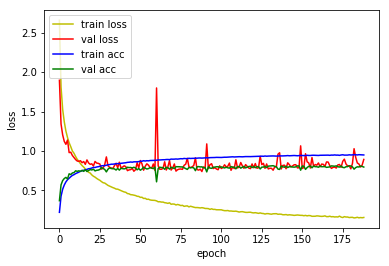

4815/4815 [==============================] - 1s 275us/sample - loss: 0.8090 - acc: 0.7807
Loss: 0.8090206719880783 Accuracy: 0.78068537

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4695 - acc: 0.2629
Epoch 00001: val_loss improved from inf to 1.69677, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_5_conv_checkpoint/001-1.6968.hdf5
36805/36805 [==============================] - 23s 624us/sample - loss: 2.4693 - acc: 0.2629 - val_loss: 1.6968 - val_acc: 0.4559
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6346 - acc: 0.4826
Epoch 00002: val_loss improved from 1.69677 to 1.21809, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_5_conv_checkpoint/002-1.2181.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.6346 - acc: 0.4826 - val_loss: 1.2181 - val_acc: 0.6382
Epoch 3/500
36736/36805 [============================>.] - E

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4203 - acc: 0.8714
Epoch 00024: val_loss did not improve from 0.50773
36805/36805 [==============================] - 16s 447us/sample - loss: 0.4203 - acc: 0.8713 - val_loss: 0.5268 - val_acc: 0.8560
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4112 - acc: 0.8757
Epoch 00025: val_loss improved from 0.50773 to 0.49891, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_5_conv_checkpoint/025-0.4989.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4112 - acc: 0.8757 - val_loss: 0.4989 - val_acc: 0.8682
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4001 - acc: 0.8802
Epoch 00026: val_loss did not improve from 0.49891
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4001 - acc: 0.8802 - val_loss: 0.5141 - val_acc: 0.8602
Epoch 27/500
36800/36805 [============================>.] - ETA:

Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2307 - acc: 0.9268
Epoch 00051: val_loss did not improve from 0.43218
36805/36805 [==============================] - 16s 439us/sample - loss: 0.2307 - acc: 0.9269 - val_loss: 0.5152 - val_acc: 0.8607
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2315 - acc: 0.9253
Epoch 00052: val_loss did not improve from 0.43218
36805/36805 [==============================] - 17s 455us/sample - loss: 0.2315 - acc: 0.9253 - val_loss: 0.4789 - val_acc: 0.8744
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2281 - acc: 0.9276
Epoch 00053: val_loss improved from 0.43218 to 0.42319, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_5_conv_checkpoint/053-0.4232.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 0.2282 - acc: 0.9276 - val_loss: 0.4232 - val_acc: 0.8894
Epoch 54/500
36800/36805 [============================>.] - ETA:

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9501
Epoch 00080: val_loss did not improve from 0.41328
36805/36805 [==============================] - 17s 461us/sample - loss: 0.1538 - acc: 0.9501 - val_loss: 0.4516 - val_acc: 0.8898
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9512
Epoch 00081: val_loss did not improve from 0.41328
36805/36805 [==============================] - 17s 452us/sample - loss: 0.1535 - acc: 0.9512 - val_loss: 0.4463 - val_acc: 0.8917
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1499 - acc: 0.9524
Epoch 00082: val_loss did not improve from 0.41328
36805/36805 [==============================] - 17s 450us/sample - loss: 0.1499 - acc: 0.9524 - val_loss: 0.4617 - val_acc: 0.8849
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9518
Epoch 00083: val_loss did not improve from 0.41328
36805/36805 [=====

Epoch 110/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9636
Epoch 00110: val_loss did not improve from 0.41328
36805/36805 [==============================] - 16s 434us/sample - loss: 0.1130 - acc: 0.9636 - val_loss: 0.4517 - val_acc: 0.8940
Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9654
Epoch 00111: val_loss did not improve from 0.41328
36805/36805 [==============================] - 16s 440us/sample - loss: 0.1100 - acc: 0.9654 - val_loss: 0.4478 - val_acc: 0.8917
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9643
Epoch 00112: val_loss did not improve from 0.41328
36805/36805 [==============================] - 17s 450us/sample - loss: 0.1105 - acc: 0.9643 - val_loss: 0.4389 - val_acc: 0.8975
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9665
Epoch 00113: val_loss did not improve from 0.41328
36805/36805 [=

Epoch 139/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9719
Epoch 00139: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0885 - acc: 0.9720 - val_loss: 0.4499 - val_acc: 0.8994
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9724
Epoch 00140: val_loss did not improve from 0.40968
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0885 - acc: 0.9724 - val_loss: 0.4900 - val_acc: 0.8898
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9718
Epoch 00141: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0899 - acc: 0.9718 - val_loss: 0.4509 - val_acc: 0.9036
Epoch 142/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0877 - acc: 0.9724
Epoch 00142: val_loss did not improve from 0.40968
36805/36805 [=

Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0727 - acc: 0.9769
Epoch 00169: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0727 - acc: 0.9769 - val_loss: 0.4470 - val_acc: 0.8970
Epoch 170/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9771
Epoch 00170: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 439us/sample - loss: 0.0742 - acc: 0.9771 - val_loss: 0.4336 - val_acc: 0.9043
Epoch 171/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9788
Epoch 00171: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 435us/sample - loss: 0.0699 - acc: 0.9788 - val_loss: 0.4491 - val_acc: 0.9061
Epoch 172/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9793
Epoch 00172: val_loss did not improve from 0.40968
36805/36805 [=

Epoch 199/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9805
Epoch 00199: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 432us/sample - loss: 0.0646 - acc: 0.9805 - val_loss: 0.4348 - val_acc: 0.9082
Epoch 200/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9801
Epoch 00200: val_loss did not improve from 0.40968
36805/36805 [==============================] - 16s 435us/sample - loss: 0.0646 - acc: 0.9801 - val_loss: 0.4726 - val_acc: 0.8987
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9807
Epoch 00201: val_loss did not improve from 0.40968
36805/36805 [==============================] - 17s 455us/sample - loss: 0.0631 - acc: 0.9807 - val_loss: 0.4398 - val_acc: 0.9040
Epoch 202/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9825
Epoch 00202: val_loss did not improve from 0.40968
36805/36805 [=

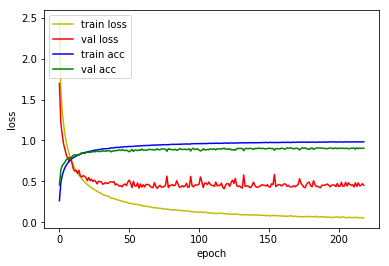

4815/4815 [==============================] - 1s 305us/sample - loss: 0.4895 - acc: 0.8737
Loss: 0.4894733119357536 Accuracy: 0.8737279

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3346 - acc: 0.2973
Epoch 00001: val_loss improved from inf to 1.52820, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_6_conv_checkpoint/001-1.5282.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 2.3347 - acc: 0.2973 - val_loss: 1.5282 - val_acc: 0.5176
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4914 - acc: 0.5225
Epoch 00002: val_loss improved from 1.52820 to 1.10314, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_6_conv_checkpoint/002-1.1031.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 1.4918 - acc: 0.5225 - val_loss: 1.1031 - val_acc: 0.6560
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2104 - acc: 0.9351
Epoch 00024: val_loss improved from 0.28089 to 0.26447, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_6_conv_checkpoint/024-0.2645.hdf5
36805/36805 [==============================] - 18s 500us/sample - loss: 0.2103 - acc: 0.9351 - val_loss: 0.2645 - val_acc: 0.9271
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9357
Epoch 00025: val_loss improved from 0.26447 to 0.25197, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_6_conv_checkpoint/025-0.2520.hdf5
36805/36805 [==============================] - 18s 494us/sample - loss: 0.2044 - acc: 0.9357 - val_loss: 0.2520 - val_acc: 0.9306
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1930 - acc: 0.9382
Epoch 00026: val_loss did not improve from 0.25197
36805/36805 [==============================] - 18s 489us/sample - loss: 0.1930 - acc: 0.9382

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9721
Epoch 00052: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 471us/sample - loss: 0.0861 - acc: 0.9721 - val_loss: 0.2535 - val_acc: 0.9371
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0858 - acc: 0.9722
Epoch 00053: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0858 - acc: 0.9722 - val_loss: 0.2437 - val_acc: 0.9378
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9727
Epoch 00054: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 471us/sample - loss: 0.0837 - acc: 0.9727 - val_loss: 0.2470 - val_acc: 0.9352
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9733
Epoch 00055: val_loss did not improve from 0.22327
36805/36805 [=====

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9853
Epoch 00082: val_loss did not improve from 0.22327
36805/36805 [==============================] - 18s 476us/sample - loss: 0.0461 - acc: 0.9853 - val_loss: 0.3357 - val_acc: 0.9264
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9865
Epoch 00083: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0443 - acc: 0.9865 - val_loss: 0.2603 - val_acc: 0.9406
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9851
Epoch 00084: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 474us/sample - loss: 0.0451 - acc: 0.9850 - val_loss: 0.3605 - val_acc: 0.9199
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9852
Epoch 00085: val_loss did not improve from 0.22327
36805/36805 [=====

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9908
Epoch 00112: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 475us/sample - loss: 0.0301 - acc: 0.9908 - val_loss: 0.2674 - val_acc: 0.9443
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9897
Epoch 00113: val_loss did not improve from 0.22327
36805/36805 [==============================] - 18s 477us/sample - loss: 0.0325 - acc: 0.9897 - val_loss: 0.2752 - val_acc: 0.9450
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9906
Epoch 00114: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 472us/sample - loss: 0.0307 - acc: 0.9906 - val_loss: 0.3096 - val_acc: 0.9287
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9907
Epoch 00115: val_loss did not improve from 0.22327
36805/36805 [=

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9928
Epoch 00142: val_loss did not improve from 0.22327
36805/36805 [==============================] - 18s 480us/sample - loss: 0.0236 - acc: 0.9928 - val_loss: 0.3167 - val_acc: 0.9380
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9910
Epoch 00143: val_loss did not improve from 0.22327
36805/36805 [==============================] - 17s 471us/sample - loss: 0.0272 - acc: 0.9910 - val_loss: 0.3249 - val_acc: 0.9378
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9936
Epoch 00144: val_loss did not improve from 0.22327
36805/36805 [==============================] - 18s 477us/sample - loss: 0.0199 - acc: 0.9936 - val_loss: 0.2982 - val_acc: 0.9408
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9929
Epoch 00145: val_loss did not improve from 0.22327
36805/36805 [=

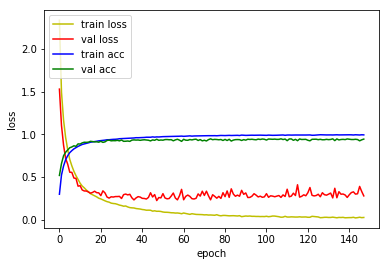

4815/4815 [==============================] - 2s 360us/sample - loss: 0.2762 - acc: 0.9192
Loss: 0.27623994896964 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9018 - acc: 0.4293
Epoch 00001: val_loss improved from inf to 1.13764, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_7_conv_checkpoint/001-1.1376.hdf5
36805/36805 [==============================] - 31s 846us/sample - loss: 1.9017 - acc: 0.4293 - val_loss: 1.1376 - val_acc: 0.6420
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0091 - acc: 0.6816
Epoch 00002: val_loss improved from 1.13764 to 0.58048, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_7_conv_checkpoint/002-0.5805.hdf5
36805/36805 [==============================] - 19s 509us/sample - loss: 1.0090 - acc: 0.6816 - val_loss: 0.5805 - val_acc: 0.8274
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0676 - acc: 0.9787
Epoch 00025: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 508us/sample - loss: 0.0676 - acc: 0.9787 - val_loss: 0.2123 - val_acc: 0.9418
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9790
Epoch 00026: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 505us/sample - loss: 0.0657 - acc: 0.9789 - val_loss: 0.2101 - val_acc: 0.9453
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9793
Epoch 00027: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 512us/sample - loss: 0.0658 - acc: 0.9793 - val_loss: 0.1876 - val_acc: 0.9483
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9824
Epoch 00028: val_loss did not improve from 0.18058
36805/36805 [==================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9940
Epoch 00055: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 508us/sample - loss: 0.0197 - acc: 0.9940 - val_loss: 0.2350 - val_acc: 0.9481
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9907
Epoch 00056: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 506us/sample - loss: 0.0307 - acc: 0.9907 - val_loss: 0.2073 - val_acc: 0.9546
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9945
Epoch 00057: val_loss did not improve from 0.18058
36805/36805 [==============================] - 19s 510us/sample - loss: 0.0192 - acc: 0.9945 - val_loss: 0.2371 - val_acc: 0.9478
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9948
Epoch 00058: val_loss improved from 0.18058 to 0.17734, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9972
Epoch 00084: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0099 - acc: 0.9971 - val_loss: 0.2118 - val_acc: 0.9527
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9941
Epoch 00085: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 514us/sample - loss: 0.0197 - acc: 0.9941 - val_loss: 0.1839 - val_acc: 0.9578
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9974
Epoch 00086: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 512us/sample - loss: 0.0091 - acc: 0.9974 - val_loss: 0.2369 - val_acc: 0.9502
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9967
Epoch 00087: val_loss did not improve from 0.17734
36805/36805 [==================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9961
Epoch 00114: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0125 - acc: 0.9960 - val_loss: 0.2138 - val_acc: 0.9567
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9955
Epoch 00115: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 508us/sample - loss: 0.0166 - acc: 0.9955 - val_loss: 0.2721 - val_acc: 0.9448
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9979
Epoch 00116: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 509us/sample - loss: 0.0069 - acc: 0.9979 - val_loss: 0.2374 - val_acc: 0.9569
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9981
Epoch 00117: val_loss did not improve from 0.17734
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9977
Epoch 00143: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 527us/sample - loss: 0.0074 - acc: 0.9977 - val_loss: 0.2717 - val_acc: 0.9518
Epoch 144/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9971
Epoch 00144: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 527us/sample - loss: 0.0097 - acc: 0.9971 - val_loss: 0.2713 - val_acc: 0.9506
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9977
Epoch 00145: val_loss did not improve from 0.17734
36805/36805 [==============================] - 19s 524us/sample - loss: 0.0075 - acc: 0.9977 - val_loss: 0.2667 - val_acc: 0.9511
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9978
Epoch 00146: val_loss did not improve from 0.17734
36805/36805 [===============

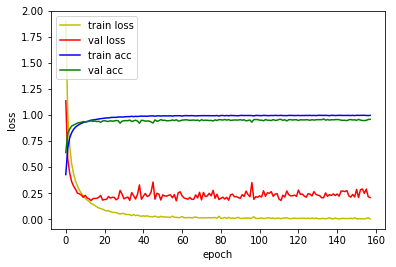

4815/4815 [==============================] - 2s 425us/sample - loss: 0.2332 - acc: 0.9445
Loss: 0.23323770014536283 Accuracy: 0.9445483

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4324 - acc: 0.5681
Epoch 00001: val_loss improved from inf to 0.94750, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_8_conv_checkpoint/001-0.9475.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.4325 - acc: 0.5680 - val_loss: 0.9475 - val_acc: 0.6993
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6471 - acc: 0.7941
Epoch 00002: val_loss improved from 0.94750 to 0.43859, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_8_conv_checkpoint/002-0.4386.hdf5
36805/36805 [==============================] - 22s 590us/sample - loss: 0.6472 - acc: 0.7941 - val_loss: 0.4386 - val_acc: 0.8593
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9928
Epoch 00027: val_loss did not improve from 0.21848
36805/36805 [==============================] - 22s 585us/sample - loss: 0.0248 - acc: 0.9928 - val_loss: 0.2460 - val_acc: 0.9371
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9928
Epoch 00028: val_loss did not improve from 0.21848
36805/36805 [==============================] - 22s 593us/sample - loss: 0.0249 - acc: 0.9928 - val_loss: 0.3359 - val_acc: 0.9243
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9929
Epoch 00029: val_loss did not improve from 0.21848
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0240 - acc: 0.9929 - val_loss: 0.2765 - val_acc: 0.9311
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9923
Epoch 00030: val_loss did not improve from 0.21848
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9929
Epoch 00056: val_loss did not improve from 0.21253
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0239 - acc: 0.9929 - val_loss: 0.2267 - val_acc: 0.9497
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.21253
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0135 - acc: 0.9961 - val_loss: 0.2433 - val_acc: 0.9474
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.9986
Epoch 00058: val_loss did not improve from 0.21253
36805/36805 [==============================] - 21s 581us/sample - loss: 0.0056 - acc: 0.9986 - val_loss: 0.2392 - val_acc: 0.9483
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9978
Epoch 00059: val_loss did not improve from 0.21253
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9979
Epoch 00085: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 590us/sample - loss: 0.0069 - acc: 0.9979 - val_loss: 0.2350 - val_acc: 0.9539
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9979
Epoch 00086: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 598us/sample - loss: 0.0064 - acc: 0.9979 - val_loss: 0.3168 - val_acc: 0.9313
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9982
Epoch 00087: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 598us/sample - loss: 0.0065 - acc: 0.9982 - val_loss: 0.2958 - val_acc: 0.9415
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9961
Epoch 00088: val_loss did not improve from 0.21194
36805/36805 [==================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9971
Epoch 00115: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 590us/sample - loss: 0.0104 - acc: 0.9971 - val_loss: 0.2307 - val_acc: 0.9506
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9990
Epoch 00116: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 595us/sample - loss: 0.0032 - acc: 0.9990 - val_loss: 0.2376 - val_acc: 0.9536
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9992
Epoch 00117: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 595us/sample - loss: 0.0028 - acc: 0.9992 - val_loss: 0.2554 - val_acc: 0.9529
Epoch 118/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9978
Epoch 00118: val_loss did not improve from 0.21194
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9973
Epoch 00144: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 597us/sample - loss: 0.0099 - acc: 0.9972 - val_loss: 0.2233 - val_acc: 0.9571
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9982
Epoch 00145: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 596us/sample - loss: 0.0066 - acc: 0.9982 - val_loss: 0.2248 - val_acc: 0.9553
Epoch 146/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9997
Epoch 00146: val_loss did not improve from 0.21194
36805/36805 [==============================] - 22s 595us/sample - loss: 0.0018 - acc: 0.9997 - val_loss: 0.2530 - val_acc: 0.9518
Epoch 147/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9969
Epoch 00147: val_loss did not improve from 0.21194
36805/36805 [===============

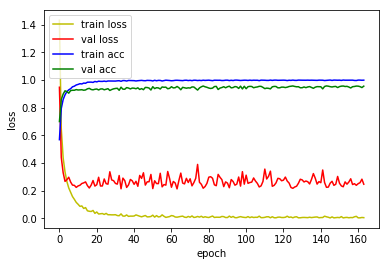

4815/4815 [==============================] - 2s 462us/sample - loss: 0.3019 - acc: 0.9310
Loss: 0.3018609445128176 Accuracy: 0.9310488



In [10]:
for i in range(1, 9):
    base = '1D_CNN_only_conv_conv_5_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_conv_5_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_36 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_36 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 42656)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 42656)             0         
_________________________________________________________________
dense_8 (Dense)              (No

4815/4815 [==============================] - 2s 380us/sample - loss: 0.8090 - acc: 0.7807
Loss: 0.8090206719880783 Accuracy: 0.78068537

1D_CNN_only_conv_conv_5_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_46 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_46 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_47 (B

4815/4815 [==============================] - 2s 467us/sample - loss: 0.2332 - acc: 0.9445
Loss: 0.23323770014536283 Accuracy: 0.9445483

1D_CNN_only_conv_conv_5_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_64 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_64 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_65 (B